# Tutorial of Using qshap for Q-SHAP

## Install the `qshap` package
`qshap` is available on PyPI. To install the package, run the following command in terminal:

In [ ]:
python -m pip install qshap

## Import packages
Before we start, we should import the `gazer` module in `qshap`.

In [45]:
from qshap import gazer

Then we import other important packages and modules for the usage of this tutorial.

In [46]:
import sklearn.ensemble
import numpy as np
import time as time
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost
from sklearn.datasets import make_regression

## Make an example data
Let's start with a toy example with 1000 samples and 1000 features.

In [47]:
np.random.seed(0)
x, y, coefficients = make_regression(n_samples=1000, n_features=1000, coef=True, random_state=0)

## Scikit-learn Decision Tree example
The initial run after import will be slower because `qshap` calls `Numba`, which uses a Just-in-Time (JIT) compiler that takes time to compile the functions.

### Fit a tree
We will use `DecisionTreeRegressor` from scikit-learn to train a decision tree on our simulated data.

In [48]:
# model fitting
# scikit learn decision tree example, the initial run after import will be slower since numba is comiling
max_depth = 2
tree_regressor = DecisionTreeRegressor(max_depth=max_depth)
tree_fit = tree_regressor.fit(x, y)

### Calculate feature-specific $R^2$
We instantiate the `gazer` class from `qshap` using the `tree_regressor` fitted in the previous stage. Then, we call the `rsq` method on this instance to calculate the Shapley $R^2$ using the `x` and `y` from our dataset.

In [49]:
gazer_rsq = gazer(tree_regressor)
rsq_res = gazer.rsq(gazer_rsq, x, y)

### Check with model $R^2$
In this section, we will check the model $R^2$ as well as the sum of Shapley $R^2$ calculated from `qshap` to verify the additivity property of Shpaley values.

In [50]:
# Let's check the model R^2
ypred = tree_regressor.predict(x)
sst = np.sum((y - np.mean(y)) ** 2)
sse = np.sum((y - ypred) ** 2)
model_rsq = 1 - sse/sst

print("Shapley R^2 sum is: " + str(np.sum(rsq_res)))
print("Model R^2 is: " + str(model_rsq) + "\n")

Shapley R^2 sum is: 0.2759939277003993
Model R^2 is: 0.2759939277003993



 ## Scikit-learn GBDT example
We will use the same dataset, but use Gradient Boosted Decision Tree (GBDT) from `scikit-learn` instead. 

### Fit GBDT

In [51]:
max_depth = 2
n_estimators = 50
tree_regressor = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth)
tree_fit = tree_regressor.fit(x, y)

### Calculate feature-specific $R^2$
Note that the usage is the same as using a decision tree as shown in the above example. We instantiate the `gazer` class from `qshap` using the `tree_regressor` fitted in the previous stage. Then, we call the `rsq` method on this instance to calculate the Shapley $R^2$ using the `x` and `y` from our dataset.

In [52]:
gazer_rsq = gazer(tree_regressor)
rsq_res = gazer.rsq(gazer_rsq, x, y)

 ## XGBoost example
We will demonstrate how to use `qshap` for xgboost in this section, on the same dataset.

### Fit XGBoost

In [53]:
max_depth = 2
n_estimators = 50
tree_regressor = xgboost.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth)
tree_regressor.fit(x, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Calculate feature-specific $R^2$
Note that the usage is the same as using a decision tree as shown in the above example. We instantiate the `gazer` class from `qshap` using the `tree_regressor` fitted in the previous stage. Then, we call the `rsq` method on this instance to calculate the Shapley $R^2$ using the `x` and `y` from our dataset.

In [54]:
gazer_rsq = gazer(tree_regressor)
rsq_res = gazer.rsq(gazer_rsq, x, y)

## Sampling 

You don't need to use all the samples for calculating Shapley $R^2$ as it would be very time-consuming if the sample size is very large. Instead, users can use part of the samples by specifying the sampling proportion through `nfrac`. 

In [55]:
gazer_rsq = gazer(tree_regressor)
rsq_res_frac = gazer.rsq(gazer_rsq, x, y, nfrac=0.5)

#  Extract loss for each sample
`qshap` calculates Shapley $R^2$ through aggregating decomposed quadratic loss function for each sample. Naturally, the package provide Shapley decomposition of quadratic function for samples. 

## Output $R^2$ and loss
Setting the argument `loss_out` to True will simply output both R squared and loss.

In [56]:
rsq_res2 = gazer.rsq(gazer_rsq, x, y, loss_out=True)
rsq_res2.rsq
rsq_res2.loss

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Loss only
If you are only intersted in loss, the decomposition of the quaratic loss could be directly calculated using the `loss` funciton of the class `gazer`. 

In [57]:
loss_res = gazer.loss(gazer_rsq, x, y)

## Loss for a specific example
Interstingly, you can calculate loss decomposition for arbitrary sample (which doesn't make sense for $R^2$).  
This will be particularly fast if you only want to several samples among a large dataset. All you have to do is add the original mean of y, in addition to the data of interest.

In [58]:
# loss decomposition for the first sample.
loss_sample1 = gazer.loss(gazer_rsq, x[0:1, :], y[0], y_mean_ori=np.mean(y))
# loss decomposition for the first 100 samples.
loss_multiple = gazer.loss(gazer_rsq, x[0:99], y[0:99], y_mean_ori=np.mean(y))

# Visualization 
This section will demonstrate how to use the visualization module in `qshap`. 

## Import module
First, we import the `vis` module of `qshap`.

In [59]:
from qshap import vis

## Quick plot
Simply call the `rsq` function of the `vis` class on the result from `gazer.rsq` to visualize.  
(`vis` is a general function that can work on numpy arrays).

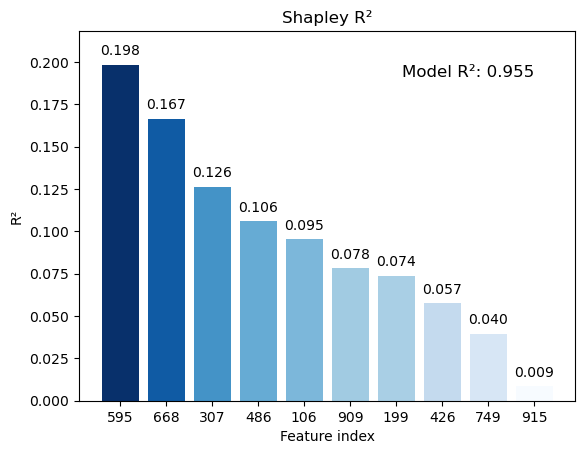

In [60]:
# default
vis.rsq(rsq_res)

## Change color

You can change the color map of the histogram by changing `color_map_name`, taking arguments from `matplotlib`, with some examples [here](https://matplotlib.org/stable/users/explain/colors/colormaps.html). In addition, you can focus on more influential by setting a cutoff of $R^2$ by changing the `cutoff` argument.

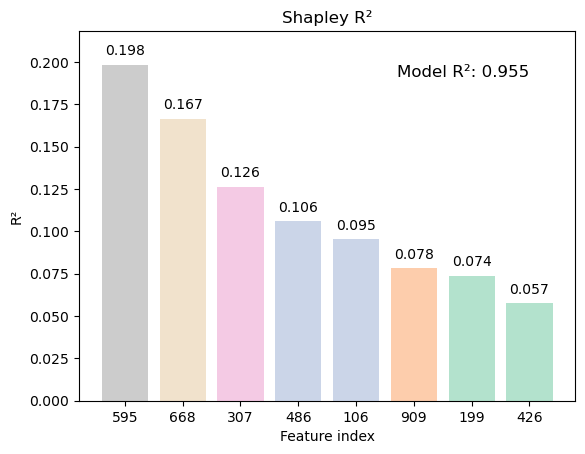

In [61]:
# change color 
vis.rsq(rsq_res, cutoff=0.05, color_map_name="Pastel2")

## More
There are many other options for the visualization function. Below is an example that outputs a horizontal plot, hides "Model $R^2$" label, changes the number of features to show, and saves the plot in pdf format with a user-specified name. 

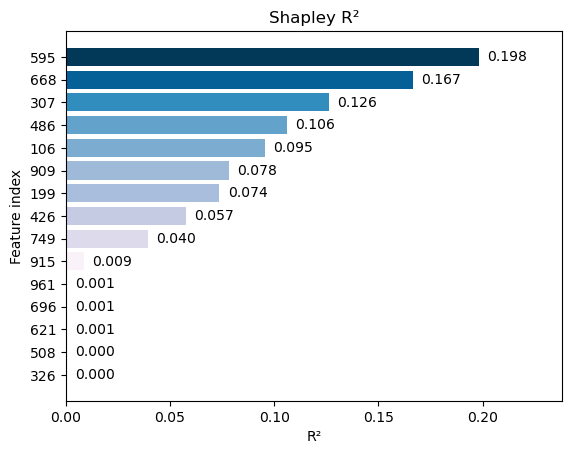

In [62]:
vis.rsq(rsq_res, color_map_name="PuBu", horizontal=True, model_rsq=False, max_feature=15, save_name="rsq_eg")

## Visualize individual loss
In addition to visualizing Shapley $R^2$, we provide the function `loss` to visualize the Shapley decomposition of individual loss function.
The plot is interactive and you can explore the sample of interest by changing the value in the box next to "Sample Index". 

Output()

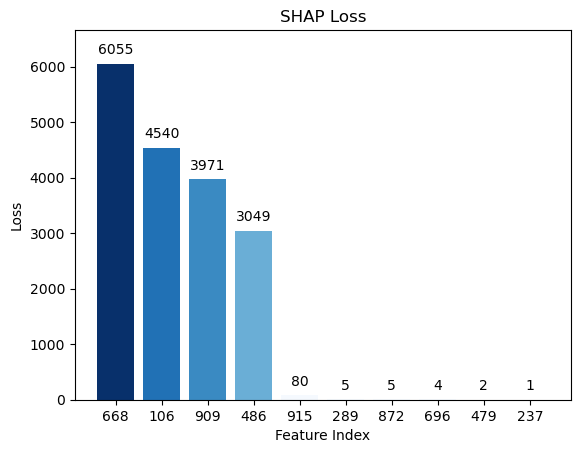

In [65]:
# Vidualize individual loss
# The interactive effect works with jupyter notebook
vis.loss(loss_res)

# Find a lovely plot for one sample and save it, say for the 10-th sample
vis.loss(loss_res, save_ind=10)

## Visualize Shapley generalized correlation
You may also be interested in the Shapley generalized correlation, which is the square root of Shapley $R^2$. You can visualize it by simply calling `gcorr` on the output of `gazer.rsq`.

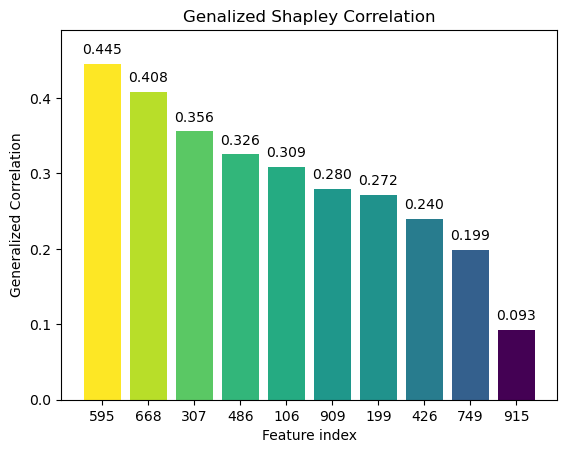

In [64]:
vis.gcorr(rsq_res, color_map_name="viridis")